# Vision Transformer (ViT)

## Reference 
- https://arxiv.org/pdf/2010.11929.pdf
- https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline
- Boostcamp AI Tech
- https://github.com/tczhangzhi/VisionTransformer-Pytorch/tree/main/vision_transformer_pytorch

## Architecture
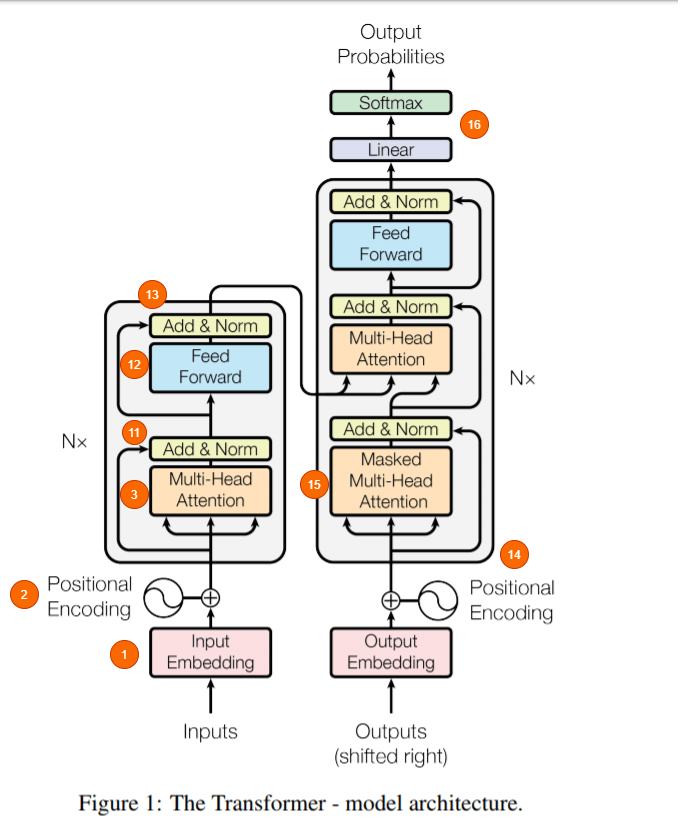
- has two parts : the decoder which is on left side, the encoder which is on the right.
- The encoduer takes the input data(sentence) and produces an intermediate representation of the input.
- The decoder decodes it step by step and generates the output.
- It is important to understand the encoder part for ViT

## Step by step overview
- (1) input data는 먼저 벡터로 표현되고, Input Embedding Layer는 학습된 벡터 표현을 잡을 수 있도록 도와준다.
- (2) positional encoding에서는 encoder가 시퀀스의 순서를 알 수 있도록 입력 임베딩에 위치 정보(인코딩)을 주입한다.
- (3) Multi-headed architecture 구조로 이동

### Multi-headed-attention architecture
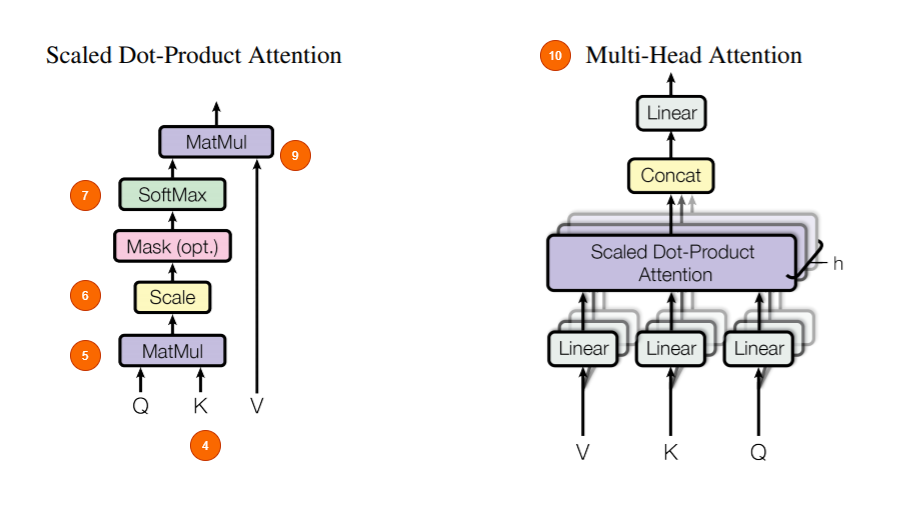

- (4) multi-headed attention은 learnable vectors가 있다. => Q, K, V (Query, Key, Value)
- (5) Q와 K는 행렬 내적 연산으로 단어가 다른 모든 단어에 얼만큼 많은 관심을 기울여야 하는지(얼만큼 상관관계가 있는지) 점수를 계산한다 (Score Matrix)
- (6) 생성된 Score Matrix는 Q와 K 백터의 차원에 따라 down scale 되고 안정적인 학습을 할 수 있도록 그라디언트를 보장하기 위함이다.
- (7) Score Matrix를 확률로 바꾸기 위해 softmax 적용한다. 이렇게 하면 모델이 관심을 가져야할 단어를 명확하게 알 수 있다.
- (8) softmax를 통과한 벡터에 V(Value)를 곱한다. 모델은 높은 확률을 가진 Socre가 더 중요해지고 반대로 Score가 낮은 단어는 관련이 없게 된다.
- (9) QK와 V 벡터를 concat하고 Linear layer에 feed한다.
- (10) 각 단어에 대해 self-attention이 수행된다. 하나의 단어는 다른 단어에 의존하지 않기 때문에 동시에 처리할 수 있다.
- (11) 출력에 입력데이터에서 오는 벡터 (Residual block)를 추가한다음 Normalization 한다. residual은 훈련 시간을 살짝 줄여주고 네트워크를 안정화 시킬 수 있다.
- (12) 더 풍부한 표현을 얻기 위해 foward feed
- (13) 한번 더 redisual vector를 더하고 normalization

### 여기까지가 Encoder

### Decoder
- (14) output 데이터는 Masked Multi-headed attention layer를 통과하고 인코더의 출력과 함께 다음 multi-headed attention layer에 입력된다. 
- (15) Masked multi-headed attention은 현재 및 이전 단어에 대한 score를 1로 설정하고 미래 단어의 score는 무한대로 설정하는데 디코딩 하는 동안 seq에서 나중에 올 단어에 대해 고려하지 않아야 하기 때문에 사용한다. 이렇게 하면 softmax를 수행할 때 미래 seq에서 미래 단어는 0으로 빠지고 나머지는 유지된다.
- (16) gradient의 flow 개선을 위해 residual이 있고 마지막 출력은 Linear layer로 연결되고 확률을 얻기 위해 softmax 함수 사용한다.

### ViT는  Transformer 에서 Encoder 부분을 사용
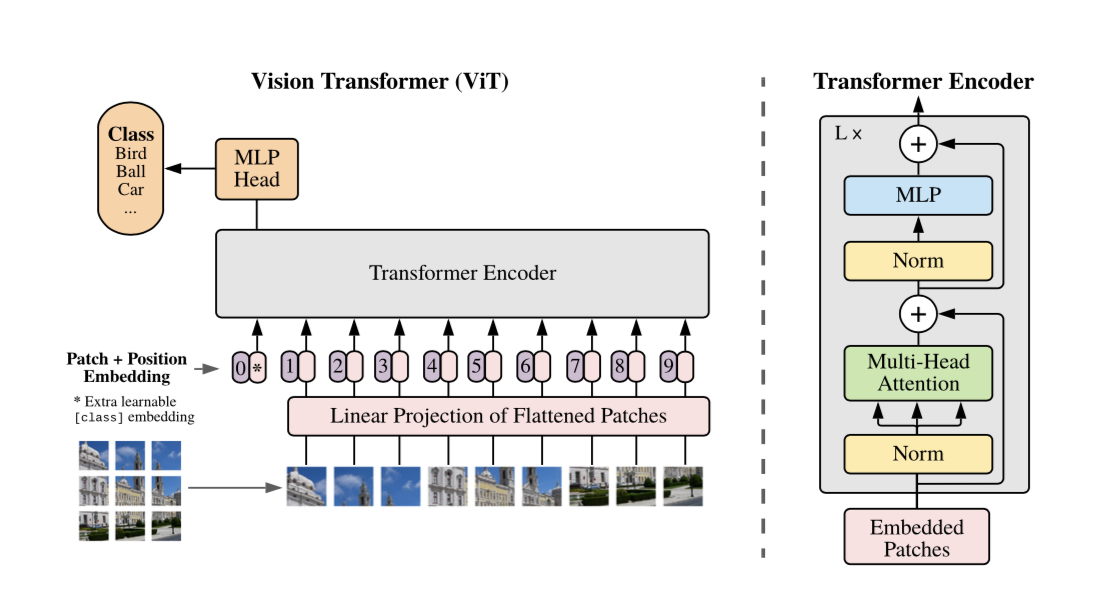

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

import time

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from torchsummary import summary

In [2]:
def seed_everything(seed):

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
 
        super(PatchEmbedding, self).__init__()    
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, ' () n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        
        return x

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0.0):
        super(MultiHeadAttention, self).__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
    
    def forward(self, x, mask=None):
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', q, k)
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        scaling = self.emb_size ** 0.5
        att = F.softmax(energy, dim=-1)
        att = self.att_drop(att)
        
        out = torch.einsum('bhal, bhlv -> bhav', att, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        
        return out

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, fn):
        super(ResidualBlock, self).__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        
        return x

In [6]:
class FeedForwardBlock(nn.Module):
    def __init__(self, emb_size, expansion=4, dropout_rate = 0.):
        super(FeedForwardBlock, self).__init__()
        self.feed = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(expansion * emb_size, emb_size),
        )
    def forward(self, x):
        out = self.feed(x)
        return out


In [7]:
class EncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, dropout_rate=0., forward_expansion=4, forward_dropout_rate=0., **kwargs):
        super(EncoderBlock, self).__init__(
            ResidualBlock(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    MultiHeadAttention(emb_size, **kwargs),
                    nn.Dropout(dropout_rate)
                )
            ),
            ResidualBlock(
                nn.Sequential(
                    nn.LayerNorm(emb_size),
                    FeedForwardBlock(emb_size, expansion=forward_expansion, dropout_rate=forward_dropout_rate),
                    nn.Dropout(dropout_rate)
                )
            )
        )

In [8]:
class Encoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[EncoderBlock(**kwargs) for _ in range(depth)])

In [9]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size=768, num_classes=1000):
        super(ClassificationHead, self).__init__()
        
        self.classifier = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )
    def forward(self, x):
        out = self.classifier(x)
        return out

In [10]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, num_classes=1000, **kwargs):
        super(VisionTransformer, self).__init__()
        self.path_embedding = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.transformer_encoder = Encoder(depth, emb_size=emb_size, **kwargs)
        self.classification_head = ClassificationHead(emb_size, num_classes)
    
    def forward(self, x):
        out = self.path_embedding(x)
        print('path embedding shape:', out.shape)
        out = self.transformer_encoder(out)
        print('transformer encoder shape:', out.shape)
        out = self.classification_head(out)
        print('transformer encoder shape:', out.shape)
        
        return out

In [11]:
x = torch.randn(8, 3, 224, 224)
out = VisionTransformer()(x)

path embedding shape: torch.Size([8, 197, 768])
transformer encoder shape: torch.Size([8, 197, 768])
transformer encoder shape: torch.Size([8, 1000])


In [12]:
summary(VisionTransformer(), (3, 224, 224), device='cpu')

path embedding shape: torch.Size([2, 197, 768])
transformer encoder shape: torch.Size([2, 197, 768])
transformer encoder shape: torch.Size([2, 1000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
    ResidualBlock-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear

In [13]:
batch_size = 128
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = torchvision.datasets.CIFAR10(root = '../data/', train = True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root = '../data/', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified
